# Coursework1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Paperspace, where you can access GPUs. 

#### Paperspace
See [the Paperspace information doc](https://hackmd.io/@afspies/S1stL8Qnt). 

The public tests are embedded within the notebook and you can ignore the **tests** folder

#### Google Colab
To run this notebook on Google Colab, please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

**To run the public tests within colab** you will need to copy the "tests" folder to the ```/content/``` directory (this is the default working directory - you can also change directories with ```%cd```)

#### Setup
You will need to install pytorch and other libraries by running the following cell:

In [1]:
!pip install -q otter-grader pandoc torch torchvision sklearn seaborn

     |████████████████████████████████| 165 kB 7.2 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 90 kB 11.4 MB/s 
     |████████████████████████████████| 117 kB 85.5 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 10.9 MB 77.0 MB/s 


In [2]:
# Initialization Cell
import otter
grader = otter.Notebook("dl_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic pytorch operations to define the 2D convolution, 2D max pooling, linear layer as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not what to see any _for loops_!

**Your Task**
- implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        
        # Bias should have shape [out_channels] 
        
        self.F = out_channels
        self.C = in_channels

        if isinstance(kernel_size, tuple):
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)

        if isinstance(stride, tuple):
            self.stride = stride
        else:
            self.stride = (stride, stride) 

        if isinstance(padding, tuple):
            self.padding = padding
        else:
            self.padding = (padding, padding) 
        
        self.w = torch.rand(self.F, self.C, self.kernel_size[0], self.kernel_size[1])
        self.bias = bias

        if bias:
            self.b = torch.rand(out_channels)
        else:
            self.b = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass

        (N, C, H, W) = x.shape

        hh = self.kernel_size[0]
        ww = self.kernel_size[1]
        px = self.padding[0]
        py = self.padding[1]
        sx = self.stride[0]
        sy = self.stride[1]

        h_out = int((H + 2 * px - (hh - 1) - 1) / sx + 1)
        w_out = int((W + 2 * py - (ww - 1) - 1) / sy + 1)

        # input unfold
        inp_unf = F.unfold(x, kernel_size=(hh, ww), dilation=1, padding=(px, py), stride=(sx, sy))

        # output unfold
        out_unf = inp_unf.transpose(1,2).matmul(self.w.view(self.w.size(0), -1).t())

        if self.bias:
            b = np.broadcast_to(self.b, shape=(N, inp_unf.size(-1), self.F))
            b = torch.tensor(b)
            out_unf = (inp_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()) + b)
        else:
            out_unf = inp_unf.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t())

        # output
        out = out_unf.transpose(1, 2).view(N, self.F, h_out, w_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [4]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        ...
        if isinstance(kernel_size, tuple):
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        (N, C, H, W) = x.shape

        hh = self.kernel_size[0]
        ww = self.kernel_size[1]

        h_out = int((H - 1 * (hh - 1) - 1)/hh + 1)
        w_out = int((W - 1 * (ww - 1) - 1)/ww + 1)

        inp_unf = F.unfold(x, kernel_size=(hh, ww), dilation=1, padding=0, stride=(hh, ww))
        inp_unf = inp_unf.transpose(-1, -2)

        inp_unf_view = inp_unf.reshape(N, -1, hh * ww)
        
        max_unf = inp_unf_view.amax(axis=2)[:, None, :]

        out_unf = max_unf.view(N, -1, C)
        out_unf = out_unf.transpose(-1, -2)
       
        out = F.fold(out_unf, (h_out, w_out), (1, 1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [6]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!

In [7]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = torch.Tensor(out_channels, in_channels)
        self.bias = bias
        if bias:
            self.b = torch.Tensor(out_channels)
        else:
            self.b = None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        if not self.bias:
            out = x @ self.w.t()
        else:
            out = x @ self.w.t() + self.b
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [8]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!

In [9]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        _shape = (num_features)
        self.gamma = nn.Parameter(torch.ones(_shape))
        self.beta = nn.Parameter(torch.zeros(_shape))  

        self.moving_mu = torch.zeros_like(self.gamma)
        self.moving_sigma = torch.ones_like(self.gamma)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Testing
        if not self.training:
            # Test time normalization operation; use self.eps as epsilon
            x_hat = (x - self.moving_mu) / torch.sqrt(self.moving_sigma + self.eps)
        
        # Training
        else:
            if len(x.shape) == 4:
                # Compute mean and var for Conv input (retaining channel dim)
                mean = x.mean(dim=(0, 2, 3), keepdim=True)
                var = x.var(dim=(0, 2, 3), keepdim=True)
            else:
                raise ValueError("Incorrect input shape!")
            

            # Training time normalization operation; use self.eps as epsilon
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            
            # Updating moving averages; use self.momentum to calculate
            # contribution to update
            self.moving_mu = self.momentum * self.moving_mu + (1.0 - self.momentum) * mean.data
            self.moving_sigma = self.momentum * self.moving_sigma + (1.0 - self.momentum) * var.data

        # Scale and shift x_hat using learnable parameters to compute output
        _shape = (1, len(self.gamma), 1, 1)
        gamma = nn.Parameter(torch.ones(_shape))
        beta = nn.Parameter(torch.zeros(_shape))  
        out = gamma * x_hat + beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [10]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (30 points)
    * 10 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (10 points)

**Downloading NaturalImageNet**

In [11]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2022-02-03 06:12:14--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1’

NaturalImageNetTest 100%[===================>] 132.09M  11.0MB/s    in 9.6s    

2022-02-03 06:12:25 (13.7 MB/s) - ‘NaturalImageNetTest.zip?download=1’ saved [138507970/138507970]

--2022-02-03 06:12:26--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1383630100 (1.3G) [application/octet-stream]
Saving to: ‘NaturalImageNetTrain.zip?download=1’

NaturalImageNetTrai 100%[===================>]   1.29G  11.2MB/s    in 2m 9s

In [20]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [21]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))

y_train_indices = train_set.indices
y_train = [train_dataset.targets[i] for i in y_train_indices]

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

print(class_sample_count)

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000
[1240  660  763  505  670 1107 1201 1016 1091  863 1424 1274  804 1281
  824  823  380  918  679  463]


In [14]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

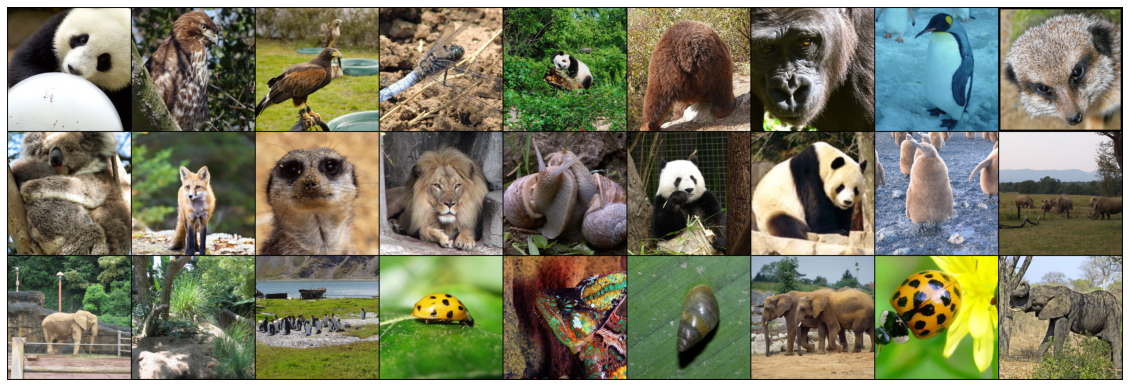

In [15]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [16]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


class SE_Layer(nn.Module):
    def __init__(self, C, r=16):
        super().__init__()
        self.C = C
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(C, C // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(C // r, C, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)


class SE_ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(SE_ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  SE_Layer(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x)   
        out += self.shortcut(x) 
        out = F.relu(out) 
        
        return out

    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 20):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 7, stride = 2,
                                            padding = 3, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(SE_ResidualBlock, 64, 2, stride = 2)
        self.layer2 = self.make_layer(SE_ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(SE_ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(SE_ResidualBlock, 512, 2, stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [18]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        check_accuracy(loader_val, model)
                

cuda:0


Total number of parameters is: 11278036
Epoch: 0, Iteration 0, loss = 3.0450
Epoch: 0, Iteration 10, loss = 2.5391
Epoch: 0, Iteration 20, loss = 2.3820
Epoch: 0, Iteration 30, loss = 2.3704
Epoch: 0, Iteration 40, loss = 2.1108
Epoch: 0, Iteration 50, loss = 1.9446
Epoch: 0, Iteration 60, loss = 1.8793
Epoch: 0, Iteration 70, loss = 1.7557
Epoch: 0, Iteration 80, loss = 1.7364
Epoch: 0, Iteration 90, loss = 1.8546
Epoch: 0, Iteration 100, loss = 1.8517
Epoch: 0, Iteration 110, loss = 1.7445
Epoch: 0, Iteration 120, loss = 1.6036
Epoch: 0, Iteration 130, loss = 1.5448
Epoch: 0, Iteration 140, loss = 1.6051
Got 978 / 1998 correct of val set (48.95)
Epoch: 1, Iteration 0, loss = 1.3900
Epoch: 1, Iteration 10, loss = 1.3407
Epoch: 1, Iteration 20, loss = 1.4388
Epoch: 1, Iteration 30, loss = 1.4443
Epoch: 1, Iteration 40, loss = 1.1122
Epoch: 1, Iteration 50, loss = 1.2238
Epoch: 1, Iteration 60, loss = 1.2404
Epoch: 1, Iteration 70, loss = 1.2848
Epoch: 1, Iteration 80, loss = 1.3469
Epo

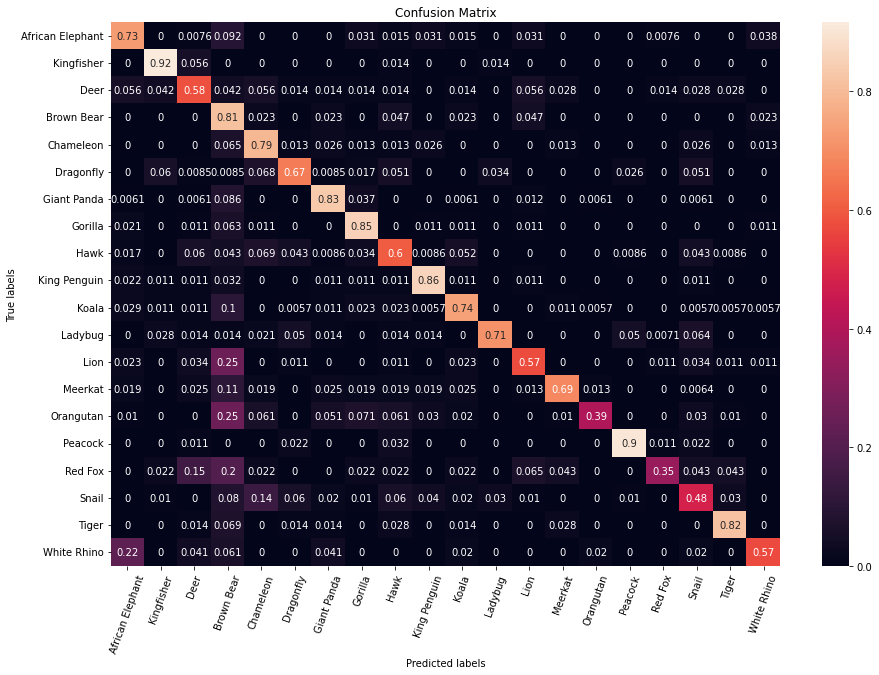

Predicted label ['Lion' 'Chameleon' 'Brown Bear' 'Deer' 'Brown Bear' 'Tiger' 'Brown Bear'
 'Deer' 'Peacock']
True label ['Brown Bear' 'Gorilla' 'Deer' 'Giant Panda' 'Meerkat' 'Orangutan' 'Hawk'
 'Meerkat' 'Snail']
Corresponding images are shown below


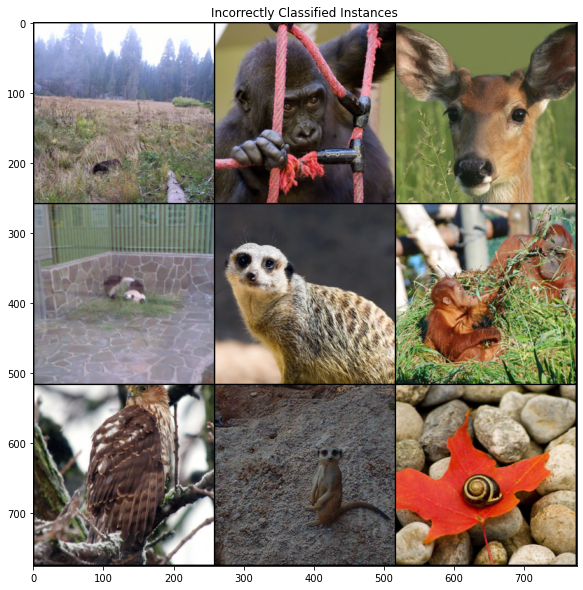

In [19]:
# define and train the network
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-7) 

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 15)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1403 / 2000 correct of val set (70.15)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


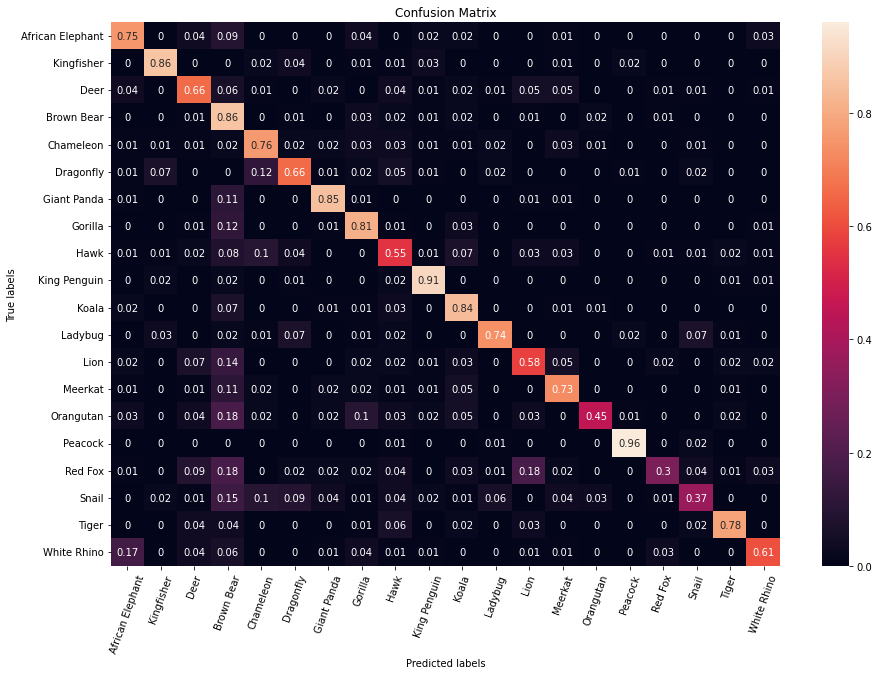

Predicted label ['Brown Bear' 'Brown Bear' 'Deer' 'African Elephant' 'Chameleon' 'Ladybug'
 'King Penguin' 'Brown Bear' 'White Rhino']
True label ['Koala' 'Tiger' 'Meerkat' 'Hawk' 'Meerkat' 'Chameleon' 'White Rhino'
 'Orangutan' 'African Elephant']
Corresponding images are shown below


0.7015

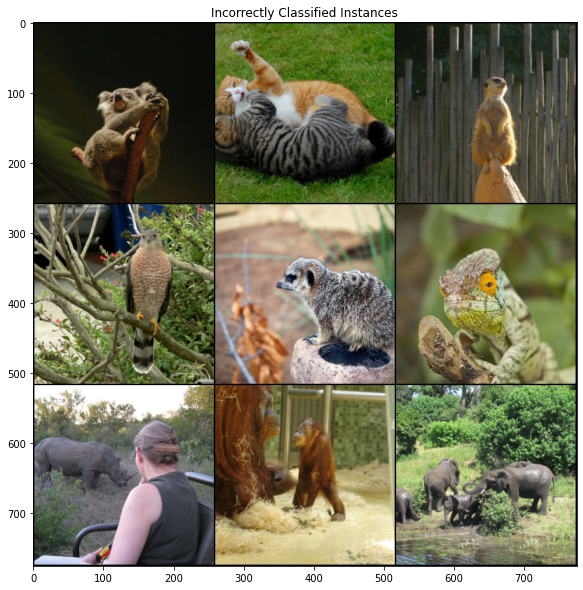

In [26]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

In this network the most important trainable parameters would be:
    - Learning rate for optimization
    - Number of epochs
    - Batch size
    - Choice of activation function
    - Architecture
    - Weight initialization
    - Dropout for regularization

Tuning all of these manually is impractical, the number of permutations is far too high. Were it in the scope of this coursework to really optimise the hyperparameters there are two generic options for searching:
1. Grid Search - This exhaustively searches all parameter combinations for given values, with a coarse search on a smaller training set followed by a narrow search on the whole training set.
2. Random Search - Picks points randomly in the configuration space instead of searching exhaustively, vastly reducing the number of iterations

Were it in the scope of this coursework, Random Search would have been the best strategy. Bergstra and Bengio's 2012 paper titled 'Random Search for Hyper-Parameter Optimization' shows both empirically and theoretically the efficiency of random trials for hyper paramater optimization over grid search. Purely random selections perform as well or better than grid search or manual tuning. Grid search should only really be used for a low dimension configuration space, maybe 3 or 4 hyperparameters.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

The key engineering decisions to trian my network were as follows:

1. Weighted random sampling - the number of samples for each class was imbalanced. This wasnt drastic but some classes had twice the number of samples in the training set as others and ideally the training set should represent a balanced spread of the dataset. I therefore used the pytorch WeightedRandomSampler module by feeding in normalized weights for each class. Then when using the dataloader I assigned this sampler so that the balance of the training set was improved. 

2. Data Augmentation - this is a technique that can be used to expand the size of the training set artificially by creating variations of images. This improves the ability of the model to generalize what it has 'learned' to new images. This was done by apply a random horizontal flip in the 'Compose' sequence. There was of course far more that could have been done here, with vertical flips, random rotations, random brightness and random zoom augmentations. However all of this takes more computational effort and storage and so I stuck to one, which improved my results. It also is worth thinking ahrd about which transformations might help for the evaluation after training, a horizontal flip or rotation is very likely for an animal, maybe a vertical flip is a lot less likely etc. Chameleon was particularly tricky to classify, maybe changingg colour would help! I didnt see marked improvements however other than the horizontal flip.

3. Architecture Changes - I tweaked the architecture provided to be the same as that demonstrated in the 'Deep Residual Learning for Image Recognition' paper to match ResNet18. This network has four instead of 6 residual blocks with different in and out channels as well as an initial kernel size of 7 rather than 3 and a few different stride sizes. This improved results likely due to the fact that it was an optimized architecture built on empirical reseach by He et al. The second change was to incorporate a 'Squeeze and Excitation' layer into the residual block. This was done according to a paper by Hu et al. in 2019 which proposes a novel new architectural unit (the SE block) that 'adaptively recalibrates channel-wise feature responses by explicitally modelling interdependencies between channels'. Essentially with the SE block, the network is better able to map the dependency of channels with access to global information. This means they are better able to recalibrate the filter outputs and this leads in turn improves performance. By changing my blocks I saw some improvement in performance and so kept the change.

4. Other hyperparameter tuning - the main changes I made here were to increase the learning rate to 0.001 in the Adammax optimizer and to increase the number of epochs from 10 to 15. The learning rate in particular dramatically improved performance. All this increase does is to increase the rate at which the weights are updated in training, but this value seemed optimum (noting as mentioned above that an exhaustive search was not possible with respect to other parameters). Increasing number of epochs, fairly obviously, improved performances as it increase training time.

It is worth noting that changes could be made to both the chocie of activation function and loss function. With regards to the activation function, ReLU is sufficient unless we see the model failing to converge and so would implement a leaky ReLU or more advanced SELU or ELU functions. Further work could also be done to determine the correct loss function, as this is the most task specific hyperparameter. However cross entropy loss seems to work well enough and is common for this type of classification task.

---

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

The code looks at the activations that are generated by the kernels as they tell us what the network is computing from a specific input. In the early layers we can see the original image fairly clearly, the edges around the animal are smooth enough to make out a penguin (in my case). Different kernels are extracting different features from the image, some seem to extract only the edges of the penguin for example getting a strong (bright) response from where these edges occur in the image. Others have a stronger response on the white of the penguins body, extracting something different here. However in all activations the penguin can be made out. 

As we progress through the layers we can see that the images become much coarser appearing as larger and larger pixelated images. As is common for ReLU networks, the activations usually start out looking relatively dense, but as the training progresses the activations usually get more sparse and localized. This happens as the convolutions pool from smaller and smaller 'blocks' of inputs. This also means it is far more difficult to interpret what the activations are actually extracting, it becomes less intuitive, and largely uninterpretable by humans. We could speculate, for example, that the strong response on some of the larger pixels in layer 4 are drawing attention to the animals face for example, or the land that it stands on. This would demsonatrate the depper layers picking up higehr features.

We really have to start speculating as to why these specific neurons are activated. Further research would be necessary to find out more such as using occlusion (This approach has been used in Matthew Zeiler’s Visualizing and Understanding Convolutional Networks) or maximal activation (Rich feature hierarchies for accurate object detection and semantic segmentation by Ross Girshick et al.).

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

Training log accuracy (Epoch 15): 70.42%
Test set accuracy: 70.15%

This performance is relatively good with regards to the size of the dataset and the lack of real hyperparameter optimisation. Needless to say it could certainly improve, the ResNet paper quoted 'An ensemble of these residual nets achieves 3.57% error on the ImageNet test set'. There is therefore huge room for improvement. The error is likely to come from the following:

    - Incompleteness of data sample.
    - Noise in the data.
    - Stochastic nature of the modeling algorithm.

Most novel architectures boil down to ResNet so nothing drastic needs to change in terms of the arhcitecture of the net. Deeper is not necessarily better if the function space is not regularized, and so trying this would not necessarily improve the algorithm. There would of course be further tweaks to the architecture to improve it, but nothing drastically would change. My accuracy numbers were increasing so if this were to run for 100 epochs for example I would expect a much higher accuracy, above 80%. Realistically much higher than this could indicate tuning my parameters to overfit to the test data and so we can consider my performance reasonable.

The main benefits would come from expanding the dataset and having more samples to train from. Additionally further data augmentation could also be likely to achieve an improvement, my network appears to struggle with images that have more than one animal in them, so careful attention to the correct transformation to artifically extend for this case would help. The images themselves are also 256x256 pixels, which is relatively small, meaning that there are inherently noisier features as they are not that well defined. This also explains why a higher accuracy is not achievable. 

The key thing to improve as previously mentioned, would be to employ a thorough hyperparameter optimization algorithm, this would lead to significant gains, and closer to the high accuracy achieved by He et al. We could also use model ensembles, by training multiple independent models and average their predictions.

With regards to the feature mapping my network appears to have avoided the dangerous pitfall that is often noticed that some activation maps may be all zero for many different inputs. This can indicate dead filters, and can be a symptom of high learning rates. This is not a problem in my case, although perhaps the early layers do appear very similar, more kernels could be used, or again further tuning of hyperparameters could improve this.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

We have the option of evaluating using Recall, Precision and F1 scores. In this case the precision is likely to be more useful than recall as the goal is to detect all the positive samples, without caring too much about misclassified images. It will eventually work towards detecting all target objects. This is the standard approach for multi label classification problems. As errors caused by false negatives are also undesirable though not as much, F1 would also be a good evaluation metric. In the case of diagnostic medical imaging for example, aiming for high recall and precision are far more important than looking at accuracy. 

Another way to evaulate would be to use the model on a completely new dataset, and so the wights will be trained on a different underlying distribution. If the goal is eventually to use the model, then this would perhaps be a better way to evaluate overall accuracy. This is in fact the best way to measure how well a model generalises and we would expect a significant drop in accuracy as there is absolutely no overfitting on the test data. If the ResNet paper had an accuracy error of 3.57% then if used on a new dataset that was not ImageNet it would be expected to maybe double its error.

As mentioned in the previous section, model ensembles could also be used for example by taking a number of the same models and initializing the weight differently then taking an average of the accuracy.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [24]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

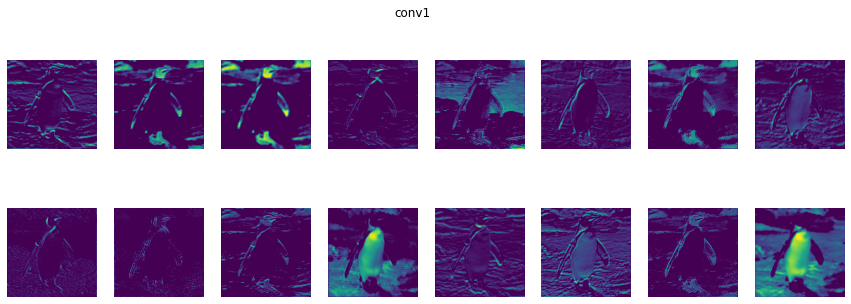

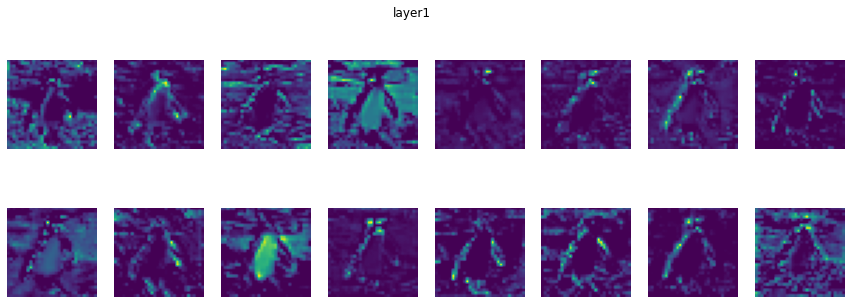

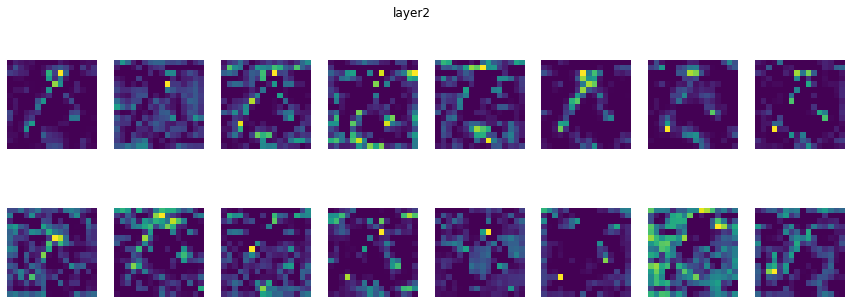

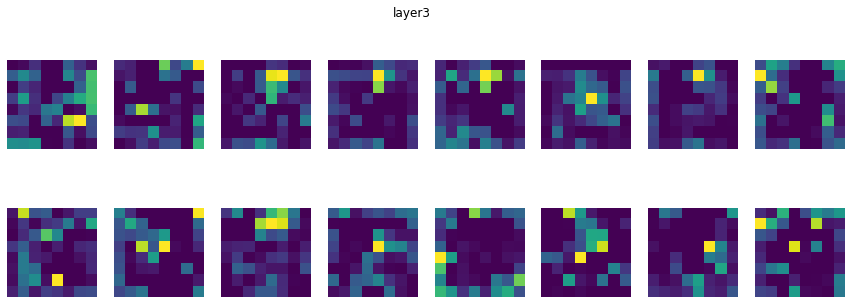

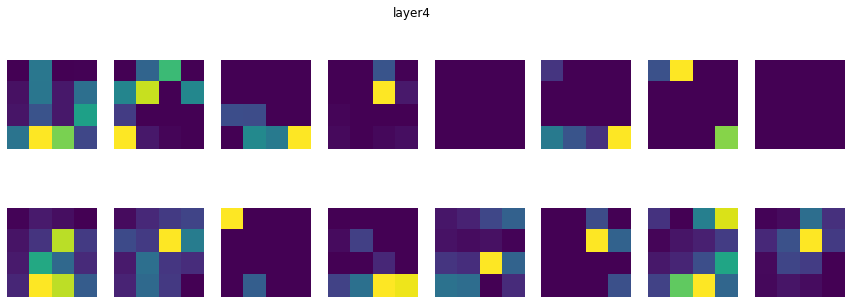

In [25]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)